## Temperature Forecast Time Series Project

Goal: Make a temperature forecast 5 days into the future from the given data.

In [163]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [164]:
# Set size of plots displayed in notebook
plt.rcParams['figure.figsize'] = (14,6)

In [165]:
# Import data
raw_data = pd.read_csv("../data/TG_STAID002759.csv")

### Data wrangling

In [170]:
raw_data.head(1)

,source_id,date,temp,q_code
0,127488,18760101,2.2,0


In [171]:
raw_data.shape

(53385, 4)

In [172]:
# Rename columns
# Data documentation - SOUID: Source identifier, DATE: YYYYMMDD, TG: Mean temp in 0.1C, Q_TG: Quality code for TG (0='valid', 1='suspect', 9='missing')
raw_data = raw_data.rename(columns={'SOUID': 'source_id', 'DATE': 'date', 'TG': 'temp', 'Q_TG': 'q_code'})

In [173]:
# Change temp units from 0.1C to 1C
raw_data['temp'] = raw_data['temp'] / 10

In [174]:
# Convert date column to datetime type and extract y/m/d into new columns
raw_data['date'] = pd.to_datetime(raw_data['date'], format="%Y%m%d")
raw_data['year'] = raw_data['date'].dt.year
raw_data['month'] = raw_data['date'].dt.month
raw_data['day'] = raw_data['date'].dt.day

In [175]:
# Remove leap days (Feb. 29) to keep standard period of 365 days per year
leap_days = raw_data.loc[(raw_data['month'] == 2) & (raw_data['day'] == 29)]

clean_days = raw_data.drop(leap_days.index)

### Replace missing values

In [176]:
# Extract date range (all NaNs are in 1945) with missing temp data
nans_45 = clean_days.loc[(clean_days['year'] == 1945) & (clean_days['q_code'] == 9)]

In [177]:
# Merge 1945 NaNs DataFrame with 1946 data in same data range 
nans_values = nans_45.merge(clean_days.loc[clean_days['year'] == 1946], on=['day', 'month'], how='left')

In [178]:
# Set index to date
nans_values = nans_values.set_index(['date_x'])
clean_days = clean_days.set_index(['date'])

In [179]:
# Replace NaN temp values in 1945 with temp values on same days in 1946 
for i in clean_days.loc['1945-04-25':'1945-11-05'].iterrows():
    clean_days['temp'].loc['1945-04-25':'1945-11-05'] = nans_values['temp_y']

/Users/happyflower/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [180]:
# Check if NaN temp values (-999) are gone
clean_days.loc[clean_days['temp'] == -999].value_counts()

Series([], dtype: int64)

In [181]:
# Check replaced values for NaN date range
clean_days.loc['1945-04-25':'1945-11-05'].head(2)

,source_id,temp,q_code,year,month,day
date,,,,,,
1945-04-25,127488,1.38,9,1945,4,25
1945-04-26,127488,1.76,9,1945,4,26


In [182]:
# Check for temp outliers for Berlin
outliers = (clean_days['temp'] > 40) | (clean_days['temp'] < -20) 
outliers.value_counts()

False    53349
Name: temp, dtype: int64

In [186]:
# Drop irrelevant columns
clean_data = clean_days.drop(columns=['source_id', 'q_code'])

### Add features: timestep, one-hot-encoding

In [187]:
# Add timestep feature (each step represents a day)
clean_data['timestep'] = list(range(len(clean_data)))

In [188]:
# Convert month and day columns into strings to create month_day column
clean_data['month'] = clean_data['month'].astype(str)
clean_data['day'] = clean_data['day'].astype(str)

In [189]:
# Create new column with month and day so there are 365 unique categories for each day of the year
clean_data['month_day'] = clean_data['month'] + '_' + clean_data['day']

In [190]:
# One-hot-encode data by seasonality of a year (period of 365 days)
dummies_seasonal = pd.get_dummies(clean_data['month_day'],
                                prefix='day',
                                drop_first=True).set_index(clean_data.index)

In [191]:
# Add ohe columns as features
clean_data = clean_data.join(dummies_seasonal)

### Split data into train and test sets

In [193]:
X_cols = clean_data.drop(columns=['temp', 'year', 'month', 'day', 'month_day']) # Keep only timestep and ohe columns
y_cols = clean_data['temp']

In [195]:
X_cols.shape

(53349, 365)

In [206]:
(53349 * 0.8) / 365 # Determining size of train set (ca. 80%) - rounding to closest year

116.92931506849317

In [208]:
117 * 365

42705

In [209]:
53349 - 42705 # Size of test set (ca. 20%)

10644

In [210]:
# Split data into train and test sets
X_train = X_cols.iloc[:42705]
X_test = X_cols.iloc[-10644:]
y_train = y_cols[:42705]
y_test = y_cols.iloc[-10644:]

In [211]:
# Check if all data is there
X_train.shape, X_test.shape, len(y_train), len(y_test)

((42705, 365), (10644, 365), 42705, 10644)

### Visualize data

In [212]:
# Merge to explore full training data
train_data = X_train.merge(pd.DataFrame(y_train), left_index=True, right_index=True, how='outer')

In [213]:
# Define plotting function
def plot_temp(data):
    data.plot()
    plt.title('Temperature per day')
    plt.ylabel('Temperature (C)')

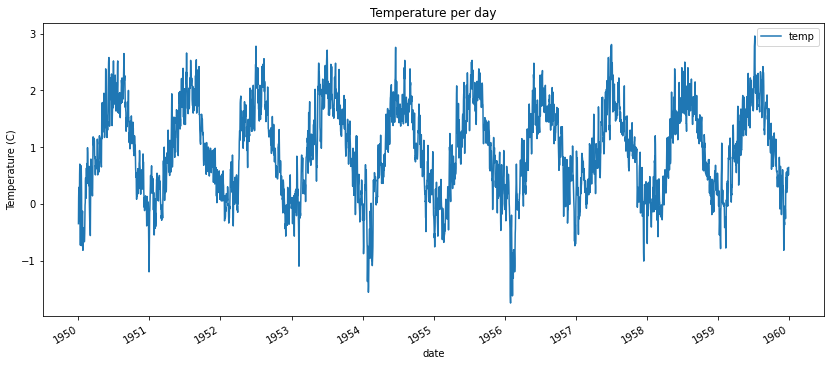

In [214]:
# Plot train data for 10 year period - zooming in to visualize seasonality (yearly)
data_year = train_data.loc['1950-01-01':'1960-01-01']

plot_temp(data_year[['temp']])

### Baseline model

In [215]:
m = LinearRegression()
m.fit(X_train, y_train)
m.score(X_train, y_train)

0.771021151491206

### Feature engineering: seasonality, lag

In [216]:
# Get seasonal trend for data
train_data['trend'] = m.predict(X_train)

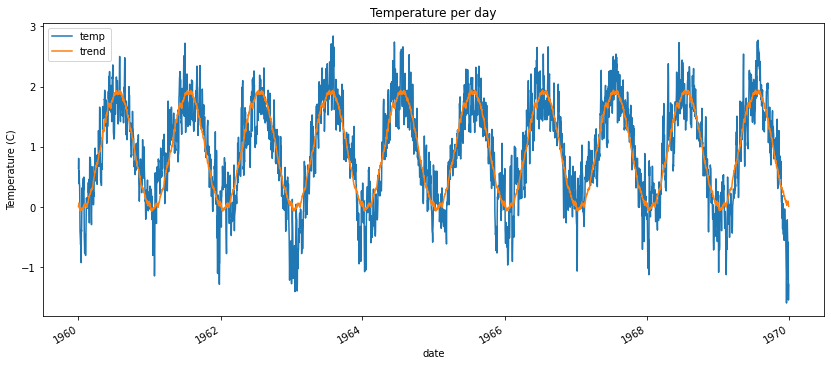

In [217]:
# Plot seasonal trend over 10 years
plot_temp(train_data.loc['1960-01-01':'1970-01-01', ['temp', 'trend']])

### Get remainder

In [218]:
# Create column with remainder between true values and trend values
train_data['remainder'] = train_data['temp'] - train_data['trend']

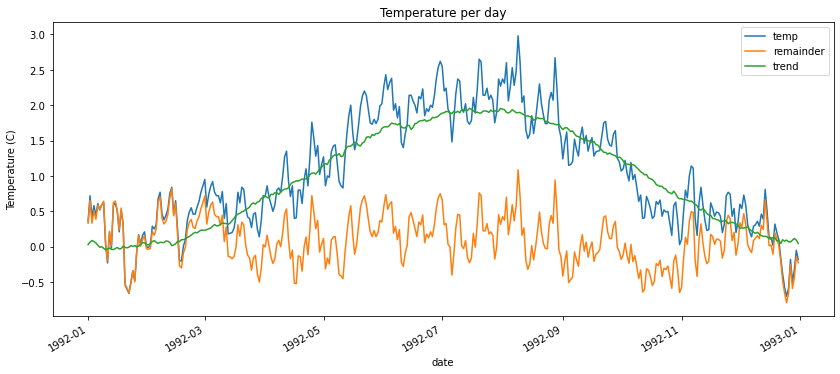

In [219]:
# Plot true value, remainder and seasonal trend
data_year = train_data.tail(365)
plot_temp(data_year[['temp', 'remainder', 'trend']])

In [220]:
train_data['remainder'].std(), train_data['temp'].std()

(0.37611245920685654, 0.7859954585196308)

### Determine number of lags

Text(0.5, 0, 'lags')

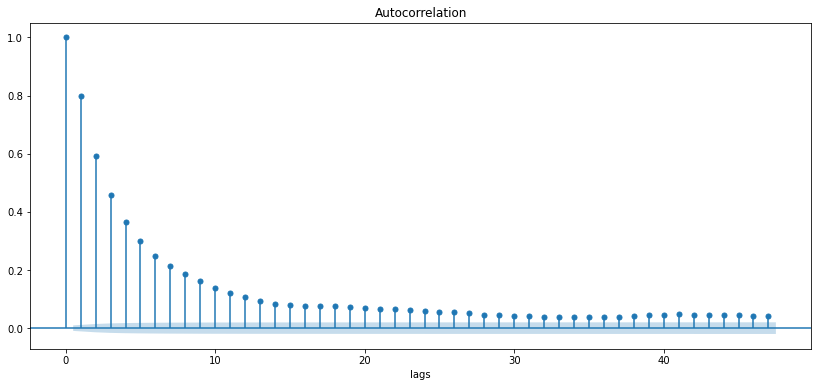

In [221]:
# Plot autocorrelation function (checks correlation between target and lags)
plot_acf(train_data['remainder'])
plt.xlabel('lags')

Text(0.5, 0, 'lags')

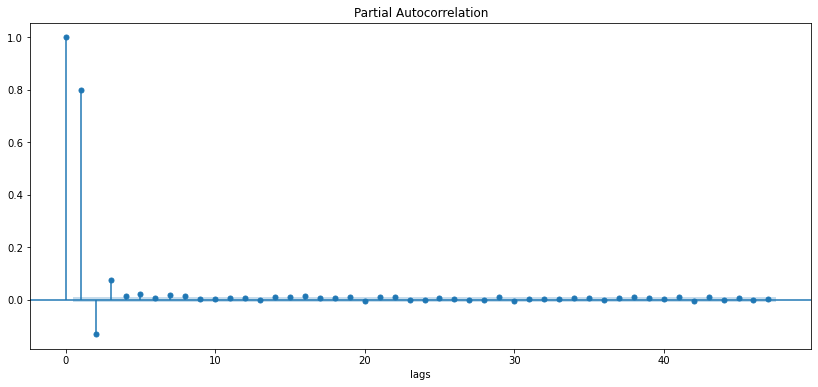

In [222]:
# Plot partial autocorrelation function (checks correlation between target and lags for regression)
plot_pacf(train_data['remainder'])
plt.xlabel('lags')

In [223]:
# Another method to determine max. lags - max. 5 lags
get_lags = ar_select_order(train_data['remainder'], maxlag = 10)
get_lags.ar_lags

/Users/happyflower/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/happyflower/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/Users/happyflower/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


array([1, 2, 3, 4, 5])

### Add lag to data

In [224]:
# Add lag columns to data (shifting down remainder column by one row)
train_data['lag1'] = train_data['remainder'].shift(1)
train_data['lag2'] = train_data['lag1'].shift(1)
train_data['lag3'] = train_data['lag2'].shift(1)
train_data['lag4'] = train_data['lag3'].shift(1)
train_data['lag5'] = train_data['lag4'].shift(1)
train_data.dropna(inplace=True) # Remove rows w/ NaN value created from shift

In [225]:
train_data.head()

,timestep,day_10_10,day_10_11,day_10_12,day_10_13,day_10_14,day_10_15,day_10_16,day_10_17,day_10_18,...,day_9_8,day_9_9,temp,trend,remainder,lag1,lag2,lag3,lag4,lag5
date,,,,,,,,,,,,,,,,,,,,,
1876-01-06,5,0,0,0,0,0,0,0,0,0,...,0,0,-0.77,-0.049235,-0.720765,-0.960167,-0.581107,0.014534,0.257013,0.263594
1876-01-07,6,0,0,0,0,0,0,0,0,0,...,0,0,-0.66,-0.080431,-0.579569,-0.720765,-0.960167,-0.581107,0.014534,0.257013
1876-01-08,7,0,0,0,0,0,0,0,0,0,...,0,0,-0.89,-0.071628,-0.818372,-0.579569,-0.720765,-0.960167,-0.581107,0.014534
1876-01-09,8,0,0,0,0,0,0,0,0,0,...,0,0,-1.27,-0.094961,-1.175039,-0.818372,-0.579569,-0.720765,-0.960167,-0.581107
1876-01-10,9,0,0,0,0,0,0,0,0,0,...,0,0,-0.89,-0.115901,-0.774099,-1.175039,-0.818372,-0.579569,-0.720765,-0.960167


### Full model

In [226]:
# Redefine X incl. lag
X_full = train_data.drop(columns=['temp', 'trend', 'remainder']) # Remove columns that derived lag column
y_full = train_data['temp']

In [227]:
# Create and fit model for full data
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [228]:
# Add new column with predicted values
train_data['prediction'] = m_full.predict(X_full)

### Plot predictions

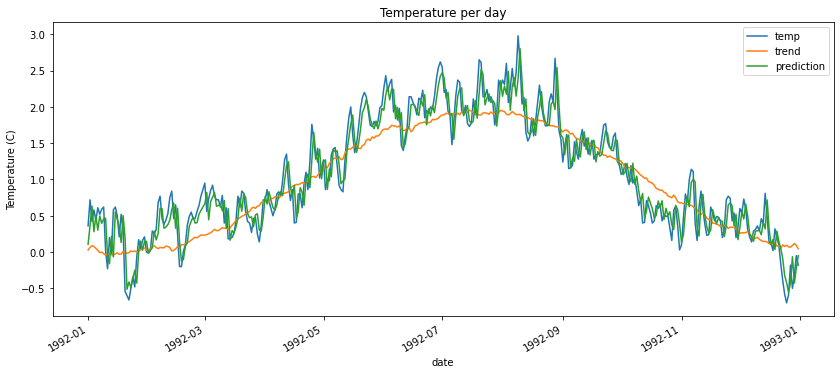

In [229]:
# Plot true values, seasonal trend and prediction for 1 year
data_year = train_data.tail(365)

plot_temp(data_year[['temp', 'trend', 'prediction']])

In [231]:
# Get coefficents
pd.DataFrame(m_full.coef_.reshape(1,370), columns=X_full.columns)

,timestep,day_10_10,day_10_11,day_10_12,day_10_13,day_10_14,day_10_15,day_10_16,day_10_17,day_10_18,...,day_9_5,day_9_6,day_9_7,day_9_8,day_9_9,lag1,lag2,lag3,lag4,lag5
0,0.000002,-0.159759,-0.190615,-0.208395,-0.234038,-0.228911,-0.277289,-0.288829,-0.301053,-0.329003,...,0.376967,0.38594,0.344058,0.313373,0.306277,0.911202,-0.197815,0.06758,-0.005557,0.022253


In [232]:
# Get intercept
m_full.intercept_

1.1769583907576346

### Evaluate model

In [233]:
# Split data using time series split to get only complete consecutive data in each set
ts_split = TimeSeriesSplit(n_splits=5)
time_split = ts_split.split(X_full, y_full) 

In [234]:
# Cross-validate model
cv_scores = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=time_split)
cv_scores

array([0.91416634, 0.9031732 , 0.92000531, 0.91890924, 0.91367677])

In [235]:
# Approx. 91% avg. accuracy for model on training data
cv_scores.mean()

0.9139861708982272

### Run model on test data

In [236]:
# Get seasonal trend for test data
X_test['trend'] = m.predict(X_test)

/var/folders/k6/wmjvb66j4r943l227ljx40000000gn/T/ipykernel_30814/1646354868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['trend'] = m.predict(X_test)


In [237]:
# Merge to explore full test data
test_data = X_test.merge(pd.DataFrame(y_test), left_index=True, right_index=True, how='outer')

<AxesSubplot:xlabel='date'>

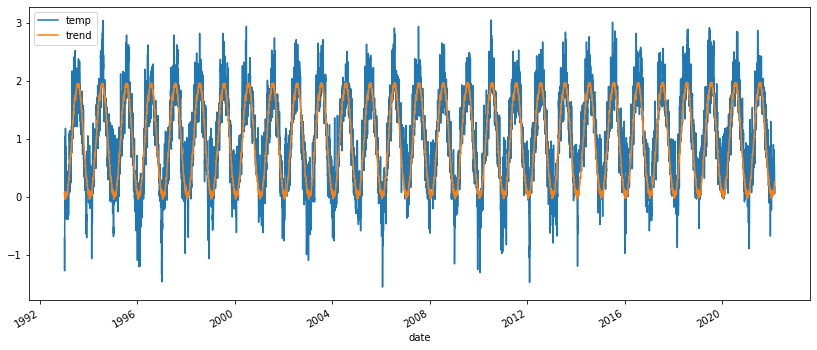

In [238]:
# Plot true values with seasonal trend
test_data[['temp', 'trend']].plot()

In [239]:
# Get remainder
test_data['remainder'] = test_data['temp'] - test_data['trend']

In [241]:
# Add lag
test_data['lag1'] = test_data['remainder'].shift(1)
test_data['lag2'] = test_data['lag1'].shift(1)
test_data['lag3'] = test_data['lag2'].shift(1)
test_data['lag4'] = test_data['lag3'].shift(1)
test_data['lag5'] = test_data['lag4'].shift(1)
test_data.dropna(inplace=True)
test_data.head(1)

,timestep,day_10_10,day_10_11,day_10_12,day_10_13,day_10_14,day_10_15,day_10_16,day_10_17,day_10_18,...,day_9_8,day_9_9,trend,temp,remainder,lag1,lag2,lag3,lag4,lag5
date,,,,,,,,,,,,,,,,,,,,,
1993-01-07,42711,0,0,0,0,0,0,0,0,0,...,0,0,-0.007492,0.33,0.337492,0.436296,-0.283106,-1.114046,-1.368405,-1.085927


In [242]:
# Redefine X
X_test_full = test_data.drop(columns=['temp', 'trend', 'remainder'])
y_test_full = test_data['temp']

In [243]:
# Add predictions
test_data['prediction'] = m_full.predict(X_test_full)

Text(0, 0.5, 'Temperature (C)')

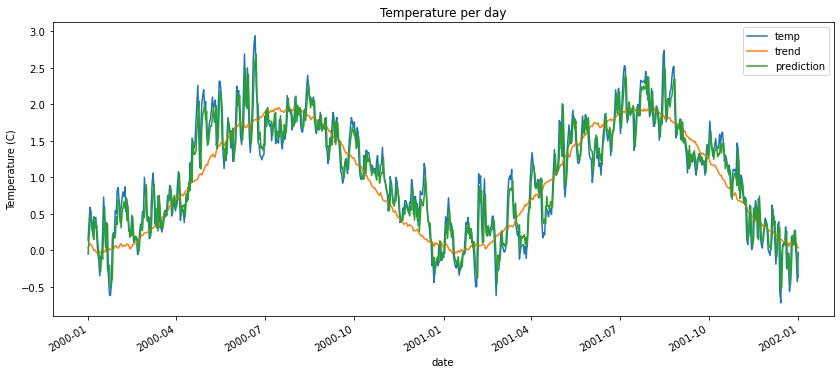

In [244]:
# Plot true values, seasonal trend and predictions for 2 year period
test_year = test_data.loc['2000-01-01':'2002-01-01']

test_year[['temp', 'trend', 'prediction']].plot()
plt.title('Temperature per day')
plt.ylabel('Temperature (C)')

In [245]:
# Split data using time series split
time_split = ts_split.split(X_test_full, y_test_full) 

In [246]:
# Cross-validate model
cv_scores = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=time_split)
cv_scores

array([0.89865351, 0.91841499, 0.92582436, 0.91976471, 0.9246343 ])

In [247]:
# Approx. 92% avg. accuracy for model on test data
cv_scores.mean()

0.9174583743486877

### Predict next 5 days' temperature

In [254]:
# Combine train and test data
all_data = train_data.append(test_data)
all_data.dropna(inplace=True) # Remove rows with NaN values

In [333]:
# Define X and y for combined data
X_all = all_data.drop(columns=['temp', 'trend', 'remainder', 'prediction'])
y_all = all_data['temp']

In [334]:
# New model for all data
m_all = LinearRegression()
m_all.fit(X_all, y_all)

LinearRegression()

In [390]:
# Create new rows for next 5 days prediction and fill in missing values

# Day 1

# lags
X_all.loc['2022-03-01', 'lag1'] = all_data.loc['2022-02-28', 'remainder']
X_all.loc['2022-03-01', 'lag2'] = all_data.loc['2022-02-28', 'lag1']
X_all.loc['2022-03-01', 'lag3'] = all_data.loc['2022-02-28', 'lag2']
X_all.loc['2022-03-01', 'lag4'] = all_data.loc['2022-02-28', 'lag3']
X_all.loc['2022-03-01', 'lag5'] = all_data.loc['2022-02-28', 'lag4']

# timestep
X_all.loc['2022-03-01', ['timestep']] = 53349.0 

# one-hot-encoding
X_all.iloc[53334:,1:365] = 0.0 
X_all.iloc[53334:,151] = 1.0

In [391]:
# Day 2

# lags
X_all.loc['2022-03-02', 'lag2'] = X_all.loc['2022-03-01', 'lag1']
X_all.loc['2022-03-02', 'lag3'] = X_all.loc['2022-03-01', 'lag2']
X_all.loc['2022-03-02', 'lag4'] = X_all.loc['2022-03-01', 'lag3']
X_all.loc['2022-03-02', 'lag5'] = X_all.loc['2022-03-01', 'lag4']

# timestep
X_all.loc['2022-03-02', ['timestep']] = 53350.0 

# one-hot-encoding
X_all.iloc[53335:,1:366] = 0.0 
X_all.iloc[53335:,162] = 1.0

In [392]:
# Day 3

# lags
X_all.loc['2022-03-03', 'lag3'] = X_all.loc['2022-03-02', 'lag2']
X_all.loc['2022-03-03', 'lag4'] = X_all.loc['2022-03-02', 'lag3']
X_all.loc['2022-03-03', 'lag5'] = X_all.loc['2022-03-02', 'lag4']

# timestep
X_all.loc['2022-03-03', ['timestep']] = 53351.0 

# one-hot-encoding
X_all.iloc[53336:,1:367] = 0.0 
X_all.iloc[53336:,173] = 1.0

In [393]:
# Day 4

# lags
X_all.loc['2022-03-04', 'lag4'] = X_all.loc['2022-03-03', 'lag3']
X_all.loc['2022-03-04', 'lag5'] = X_all.loc['2022-03-03', 'lag4']

# timestep
X_all.loc['2022-03-04', ['timestep']] = 53352.0 

# one-hot-encoding
X_all.iloc[53337:,1:368] = 0.0 
X_all.iloc[53337:,176] = 1.0

In [394]:
# Day 5

# lag
X_all.loc['2022-03-05', 'lag5'] = X_all.loc['2022-03-04', 'lag4']

# timestep
X_all.loc['2022-03-05', ['timestep']] = 53353.0 

# one-hot-encoding
X_all.iloc[53338:,1:369] = 0.0 
X_all.iloc[53338:,177] = 1.0

In [397]:
#X_all.columns.get_loc('day_3_5') # Find ohe column for the month and day

In [396]:
X_all.tail()

,timestep,day_10_10,day_10_11,day_10_12,day_10_13,day_10_14,day_10_15,day_10_16,day_10_17,day_10_18,...,day_9_5,day_9_6,day_9_7,day_9_8,day_9_9,lag1,lag2,lag3,lag4,lag5
date,,,,,,,,,,,,,,,,,,,,,
2022-03-01,53349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.08298,-0.184689,0.194627,0.218131,0.385995
2022-03-02,53350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,-0.082980,-0.184689,0.194627,0.218131
2022-03-03,53351.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,-0.082980,-0.184689,0.194627
2022-03-04,53352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,-0.082980,-0.184689
2022-03-05,53353.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,-0.082980


In [399]:
# Create DataFrame with only the future days
X_next_days = X_all.loc['2022-03-01':'2022-03-05']
X_next_days

,timestep,day_10_10,day_10_11,day_10_12,day_10_13,day_10_14,day_10_15,day_10_16,day_10_17,day_10_18,...,day_9_5,day_9_6,day_9_7,day_9_8,day_9_9,lag1,lag2,lag3,lag4,lag5
date,,,,,,,,,,,,,,,,,,,,,
2022-03-01,53349.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.08298,-0.184689,0.194627,0.218131,0.385995
2022-03-02,53350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,-0.082980,-0.184689,0.194627,0.218131
2022-03-03,53351.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,-0.082980,-0.184689,0.194627
2022-03-04,53352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,-0.082980,-0.184689
2022-03-05,53353.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,-0.082980


In [400]:
# Predict future temperature for next days with ca. 91% confidence level
m_all.predict(X_next_days)

array([0.24342381, 0.27529832, 0.28174295, 0.28411055, 0.31612533])

### Temperature forecast for the next 5 days

In [446]:
# Create DataFrame to display predicted temp for future 5 days
forecast = pd.DataFrame()
forecast['temp (°C)'] = pd.DataFrame(m_all.predict(X_next_days)).round(2) # Forecast temp
forecast.index = X_next_days.index # Dates

In [447]:
forecast

,temp (°C)
date,
2022-03-01,0.24
2022-03-02,0.28
2022-03-03,0.28
2022-03-04,0.28
2022-03-05,0.32
